In [1]:
import os, simplejson, pickle, time, parameter, importlib, greedy_path, random

from cluster_model import ClusterModel
from state_optimization import StateOptimization
from datetime import datetime, timedelta
from gurobipy import GRB
from shapely.geometry import shape, Point, Polygon, MultiPolygon
from shapely.ops import nearest_points
from matplotlib.lines import Line2D
from geojson import load

import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import integer_programming as ip
import networkx as nx


In [2]:
with open('../data/station_data/2024 model/v2/tph_4/data.pickle', 'rb') as f:
    station_data = pickle.load(f)
    
with open('../station_information.json', 'r') as f:
    station_information = simplejson.load(f)['data']['stations']
    
with open('../data/ideal_states/bounds.pickle', 'rb') as f:
    bounds = pickle.load(f)

tph = 4
square_size = 0.005

In [321]:
model = ClusterModel(station_data=station_data)

start_df = parameter.get_state_df(station_information, f'rebalancing/data/9/2024-07-09-10-00.pickle')
model.init_df_state(start_df, time=timedelta(hours=6))

original_state = {i: model.cluster_dict[i].curr_bikes for i in model.cluster_dict}
original_clusters = {cluster.name: cluster for cluster in model.cluster_dict.values()}

state_optimization = StateOptimization(model)

for cluster in model.cluster_dict.values():
    cluster.rate = [rate*1.75 for rate in cluster.rate]

36 horizontal squares and 51 vertical squares. Total squares: 1836


In [324]:
opt_state = state_optimization.optimize(length=timedelta(hours=16), steps=12, min=1.6)

Step 1 of 12 completed 4078 failures
Step 2 of 12 completed 3248 failures
Step 3 of 12 completed 2720 failures
Step 4 of 12 completed 1825 failures
Step 5 of 12 completed 2769 failures
Step 6 of 12 completed 2339 failures
Step 7 of 12 completed 1528 failures
Step 8 of 12 completed 2319 failures
Step 9 of 12 completed 2171 failures
Step 10 of 12 completed 2327 failures
Step 11 of 12 completed 2088 failures
Step 12 of 12 completed 1999 failures


In [9]:
with open("../new-york-city-boroughs.geojson") as f:
    boroughs_geojson = simplejson.load(f)
    
def classify_borough(lat, lon, boroughs_geojson):
    point = Point(lon, lat)
    min_distance = float('inf')
    nearest_borough = 'Unknown'
    
    for feature in boroughs_geojson['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']  # or appropriate property name
        # Calculate the distance to the nearest point on the polygon
        nearest_point = nearest_points(point, polygon)[1]
        distance = point.distance(nearest_point)
        if distance < min_distance:
            min_distance = distance
            nearest_borough = feature['properties']['name']
    
    return nearest_borough

boro_dict = {}
for cluster in model.cluster_dict.values():
    boro_dict[cluster.name] = classify_borough(cluster.lat, cluster.lon, boroughs_geojson)
    
clusters = []
for cluster in boro_dict:
    if boro_dict[cluster] == 'Brooklyn':
        clusters.append(cluster)

In [513]:
start_levels = {cluster.name: cluster.curr_bikes for cluster in model.cluster_dict.values() if cluster.name in clusters}
optimal_levels = {cluster: opt_state[cluster] for cluster in clusters}

difference = {}
for cluster in clusters:
    difference[cluster] = optimal_levels[cluster] - start_levels[cluster]
sorted_difference = dict(sorted(difference.items(), key=lambda item: item[1]))
sorted_clusters = [cluster for cluster in sorted_difference.keys()]
limit = 15 # take this many worst clusters on each end
worst_clusters = sorted_clusters[:limit] + sorted_clusters[-limit:]

for cluster in clusters:
    if cluster not in worst_clusters:
        start_levels[cluster] = 0
        optimal_levels[cluster] = 0
        
positions = {cluster.name: (cluster.lon, cluster.lat) for cluster in model.cluster_dict.values() if cluster.name in clusters}
adjacency = model.get_adjacent_clusters()
adjacency = {cluster: adjacency[cluster] for cluster in adjacency if cluster in clusters}
for cluster in adjacency:
    remove = []
    for adj_cluster in adjacency[cluster]:
        if adj_cluster not in clusters:
            remove.append(adj_cluster)
    for rm in remove:
        adjacency[cluster].remove(rm)

In [472]:
model.reset_state(original_state, [], timedelta(hours=6))
"""For adding iterative additional trucks"""
for cluster in increase_dict:
    model.cluster_dict[cluster].curr_bikes += increase_dict[cluster]
for cluster in decrease_dict:
    model.cluster_dict[cluster].curr_bikes -= decrease_dict[cluster]
original_state = {cluster.name: cluster.curr_bikes for cluster in model.cluster_dict.values()}
    
start_levels = {cluster.name: cluster.curr_bikes for cluster in model.cluster_dict.values() if cluster.name in clusters}
optimal_levels = {cluster: opt_state[cluster] for cluster in clusters}
positions = {cluster.name: (cluster.lon, cluster.lat) for cluster in model.cluster_dict.values() if cluster.name in clusters}
adjacency = model.get_adjacent_clusters()
adjacency = {cluster: adjacency[cluster] for cluster in adjacency if cluster in clusters}
for cluster in adjacency:
    remove = []
    for adj_cluster in adjacency[cluster]:
        if adj_cluster not in clusters:
            remove.append(adj_cluster)
    for rm in remove:
        adjacency[cluster].remove(rm)


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.5.0 22F66)

CPU model: Intel(R) Core(TM) i9-9980HK CPU @ 2.40GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 46782 rows, 22477 columns and 178378 nonzeros
Model fingerprint: 0x17554641
Variable types: 0 continuous, 22477 integer (11080 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 32388 rows and 10186 columns
Presolve time: 0.22s
Presolved: 14394 rows, 12291 columns, 82765 nonzeros
Variable types: 0 continuous, 12291 integer (11069 binary)
Found heuristic solution: objective 1089.0000000
Found heuristic solution: objective 1051.0000000

Root relaxation: objective 2.890000e+02, 6147 iterations, 1.18 seconds (1.39 work units)

Interrupt request received

    Nodes    |    Current Node    |     Objective Bounds      |     Wo

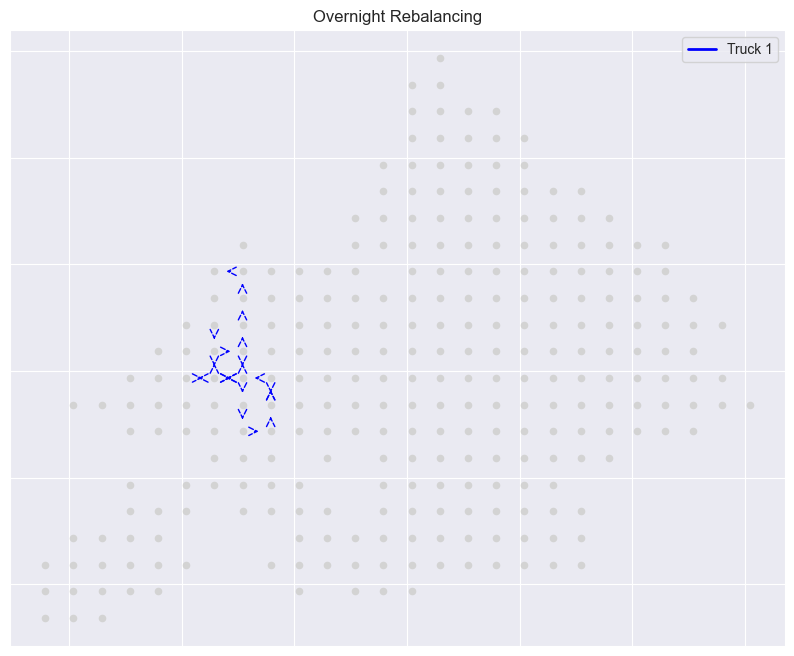

In [514]:
T = 40
K = 1
L = 30

ip_model, x, y, b = ip.create_model(T=T, K=K, L=L, 
                start_levels=start_levels,
                stations=clusters, 
                optimal_levels=optimal_levels, 
                positions=positions,  
                neighbors=adjacency)

truck_paths = ip.graph_model(x, b, K, T, clusters, positions)

In [515]:
print('TRUCK REPORTS:')
for k in range(1, K+1):
    print('\n\nTRUCK {}\n'.format(k))
    truck_data = truck_paths[k]
    increase_dict = {}
    decrease_dict = {}
    for i in range(0, len(truck_data)-1):
        if truck_data[i][1] != truck_data[i+1][1]:
            print('time {}: traveled from {} to {}'.format(truck_data[i][0],truck_data[i][1], truck_data[i+1][1]))
        if int(truck_data[i][2][0:2]) > int(truck_data[i+1][2][0:2]):
            print('time {}: dropped off {} bikes at {}'.format(truck_data[i][0],
                                                           int(truck_data[i][2][0:2]) - int(truck_data[i+1][2][0:2]), truck_data[i][1]))
            if truck_data[i][1] in increase_dict.keys():
                increase_dict[truck_data[i][1]] += int(truck_data[i][2][0:2]) - int(truck_data[i+1][2][0:2])
            else:
                increase_dict[truck_data[i][1]] = int(truck_data[i][2][0:2]) - int(truck_data[i+1][2][0:2])
        if int(truck_data[i][2][0:2]) < int(truck_data[i+1][2][0:2]):
            print('time {}: picked up {} bikes at {}'.format(truck_data[i][0],
                                                           int(truck_data[i+1][2][0:2]) - int(truck_data[i][2][0:2]), truck_data[i][1]))
            if truck_data[i][1] in decrease_dict.keys():
                    decrease_dict[truck_data[i][1]] += int(truck_data[i+1][2][0:2]) - int(truck_data[i][2][0:2])
            else:
                decrease_dict[truck_data[i][1]] = int(truck_data[i+1][2][0:2]) - int(truck_data[i][2][0:2])
                
    print('\nOVERALL IMPACT\n')
    for cluster in increase_dict:
        print('increased {} by {} bikes'.format(cluster, increase_dict[cluster]))
    
    for cluster in decrease_dict:
        print('decreased {} by {} bikes'.format(cluster, decrease_dict[cluster]))

TRUCK REPORTS:


TRUCK 1

time 1: picked up 30 bikes at 1410
time 2: traveled from 1410 to 1446
time 3: traveled from 1446 to 1482
time 4: traveled from 1482 to 1481
time 5: dropped off 30 bikes at 1481
time 6: traveled from 1481 to 1482
time 7: traveled from 1482 to 1483
time 8: traveled from 1483 to 1447
time 10: picked up 30 bikes at 1447
time 11: traveled from 1447 to 1483
time 12: traveled from 1483 to 1482
time 13: dropped off 11 bikes at 1482
time 14: traveled from 1482 to 1483
time 15: traveled from 1483 to 1519
time 16: traveled from 1519 to 1555
time 16: picked up 11 bikes at 1519
time 17: dropped off 30 bikes at 1555
time 18: traveled from 1555 to 1556
time 19: picked up 17 bikes at 1556
time 20: traveled from 1556 to 1520
time 21: picked up 13 bikes at 1520
time 22: traveled from 1520 to 1484
time 23: dropped off 30 bikes at 1484
time 24: traveled from 1484 to 1520
time 25: picked up 30 bikes at 1520
time 26: traveled from 1520 to 1484
time 27: dropped off 2 bikes at 1484
t

In [216]:
res = {}
for cluster in clusters[:100]:
    curr_bikes = 0
    max_bikes = 40
    res[cluster] = greedy_path.find_route(start=cluster, weight=weight, vertical_squares=model.vertical_squares, horizontal_squares=model.horizontal_squares, curr_bikes=curr_bikes, max_bikes=max_bikes, adjacency=adjacency, max_time=10, drop=False)
res

{1058: (1058, 1, -12),
 1093: (1093, 1, -19),
 1094: (1093, 2, -19),
 1129: (1129, 1, -26),
 1130: (1129, 2, -26),
 1131: (1131, 1, -17),
 1132: (1131, 2, -17),
 1165: (1201, 2, -27),
 1166: (1166, 1, -23),
 1167: (1166, 2, -23),
 1168: (1202, 4, -32),
 1169: (1238, 6, -40),
 1200: (1200, 1, -12),
 1201: (1201, 1, -27),
 1202: (1202, 1, -32),
 1203: (1203, 1, -21),
 1204: (1240, 2, -22),
 1205: (1202, 4, -32),
 1236: (1272, 2, -24),
 1237: (1237, 1, -20),
 1238: (1238, 1, -40),
 1239: (1238, 2, -40),
 1240: (1240, 1, -22),
 1241: (1240, 2, -22),
 1242: (1278, 2, -18),
 1243: (1238, 6, -40),
 1271: (1271, 1, -17),
 1272: (1272, 1, -24),
 1273: (1272, 2, -24),
 1274: (1238, 2, -40),
 1275: (1238, 3, -40),
 1276: (1240, 2, -22),
 1277: (1238, 5, -40),
 1278: (1278, 1, -18),
 1279: (1278, 2, -18),
 1280: (1316, 2, -22),
 1303: (1303, 1, -21),
 1307: (1378, 4, -40),
 1308: (1272, 2, -24),
 1309: (1272, 3, -24),
 1310: (1238, 3, -40),
 1311: (1238, 4, -40),
 1312: (1238, 5, -40),
 1313: (134

In [372]:
importlib.reload(greedy_path)
weight = {}
all_dif = {}
for cluster in clusters:
    weight[cluster] = opt_state[cluster] - original_state[cluster]
    
for cluster in [random.choice([i for i in clusters]) for j in range(1)]:
    route_dif, route_log = greedy_path.get_path(start=cluster, weight=weight, vertical_squares=model.vertical_squares, 
                                                horizontal_squares=model.horizontal_squares, curr_bikes=0, max_bikes=30, adjacency=adjacency, max_time=40)
    for cluster in route_dif:
        # weight[cluster] -= route_dif[cluster]
        if cluster not in all_dif:
            all_dif[cluster] = route_dif[cluster]
        else:
            all_dif[cluster] += route_dif[cluster]
print(all_dif)

Curr_bikes: 0 Time: 0 at 1316 pickup at 1316 for -22 weight -22
Curr_bikes: 22 Time: 1 at 1316 drop at 1460 for 22 weight 27
Curr_bikes: 0 Time: 6 at 1460 pickup at 1238 for -30 weight -47
Curr_bikes: 30 Time: 19 at 1238 drop at 1490 for 30 weight 31
Curr_bikes: 0 Time: 27 at 1490 pickup at 1417 for -18 weight -18
Activated drop only at time: 31
Curr_bikes: 18 Time: 31 at 1417 drop at 1380 for 18 weight 18
Curr_bikes: 0 Time: 34 at 0 drop for 0 drop True
{1316: -22, 1460: 22, 1238: -30, 1490: 30, 1417: -18, 1380: 18}


<Axes: >

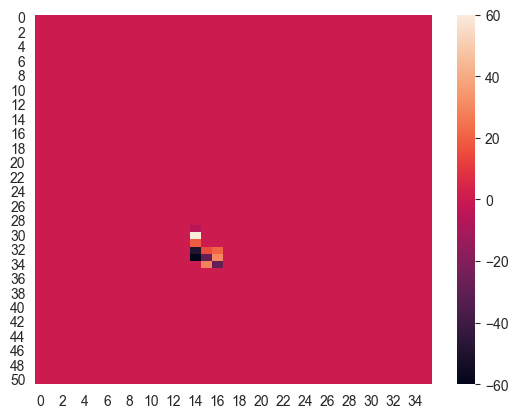

In [507]:
for cluster in clusters:
    weight[cluster] = opt_state[cluster] - original_state[cluster]
test = np.array([weight[i] if i in weight else 0 for i in range(model.horizontal_squares*model.vertical_squares)])
test_3 = np.array([all_dif[i] if i in all_dif else 0 for i in range(len(model.clusters))])
test = test.reshape(model.vertical_squares, model.horizontal_squares)
test_3 = test_3.reshape(model.vertical_squares, model.horizontal_squares)
test_2 = test - test_3
test_4 = np.array([increase_dict[i] if i in increase_dict else 0 for i in range(len(model.clusters))])
for val in decrease_dict:
    test_4[val] -= decrease_dict[val]
test_4 = test_4.reshape(model.vertical_squares, model.horizontal_squares)
# sns.heatmap(test, vmin=-75, vmax=75)\
sns.heatmap(test_4)

<Axes: >

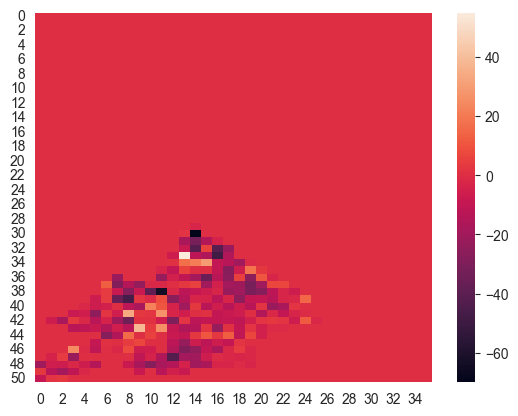

In [501]:
sns.heatmap(test)

<Axes: >

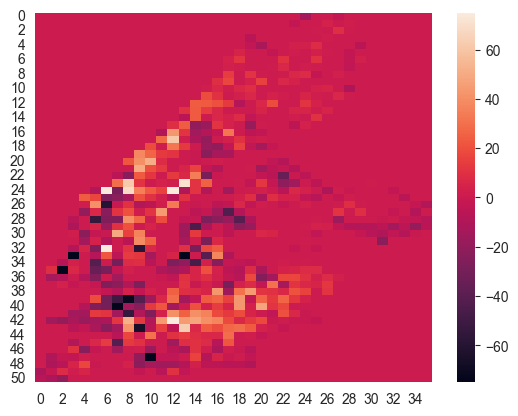

In [454]:
sns.heatmap(test_2, vmin=-75, vmax=75)

<Axes: >

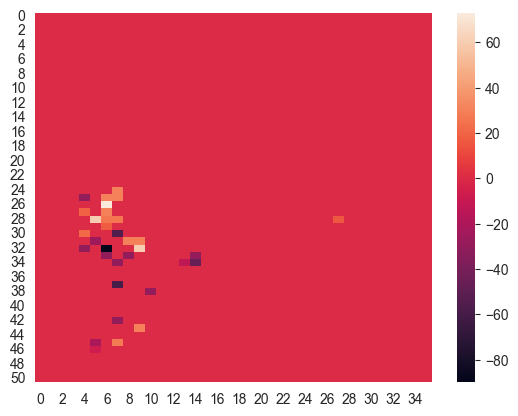

In [455]:
sns.heatmap(test_3)

In [327]:
prior_avg_failures = 0
prior_avg_brook_failures = 0
prior_avg_trips = 0
for i in range(30):
    model.reset_state(bike_state=original_state,in_transit=[], time=timedelta(hours=6))
    for j in range(16*4):
        model.sim()
    prior_avg_failures += model.failures
    prior_avg_trips += model.total_trips
    for cluster in clusters:
        prior_avg_brook_failures += len(model.cluster_dict[cluster].bad_arrivals) + len(model.cluster_dict[cluster].bad_departures)
print('Average total trips before rebalance', prior_avg_trips/30)
print('Average failures before rebalance', prior_avg_failures/30)
print('Average failures in brooklyn before rebalance', prior_avg_brook_failures/30)

Average total trips before rebalance 170040.63333333333
Average failures before rebalance 10161.266666666666
Average failures in brooklyn before rebalance 3198.866666666667


In [328]:
def time_scale(time):
    return time ** 0.85

def distance(start: int, end: int, h_sq: int):
    x_dist = abs((start - end) % h_sq)
    y_dist = abs((start // h_sq) - (end // h_sq))
    return x_dist + y_dist + 1

def find_max_route(start: int, weight: dict[int: int], h_sq:int, curr_bikes: int, max_time: int, max_bikes: int, drop: bool):
    maximum = 0
    dest = 0
    time = 1
    for cluster in weight:
        dist = distance(start=start, end=cluster, h_sq=h_sq)
        if dist > max_time and not drop:
            continue
        value = weight[cluster]
        if value < curr_bikes - max_bikes:
            value = curr_bikes - max_bikes
        if value > curr_bikes:
            value = curr_bikes
        if value < 0 and drop:
            continue
        if abs(value / time_scale(dist)) > abs(maximum / time_scale(time)):
            maximum = value
            dest = cluster
            time = dist
    return dest, time, maximum

def best_routes(start: int, weight: dict[int: int], h_sq:int, curr_bikes: int, max_time: int, max_bikes: int, drop: bool):
    data = {}
    for cluster in weight:
        dist = distance(start=start, end=cluster, h_sq=h_sq)
        if dist > max_time and not drop:
            continue
        value = weight[cluster]
        if value < curr_bikes - max_bikes:
            value = curr_bikes - max_bikes
        if value > curr_bikes:
            value = curr_bikes
        if value < 0 and drop:
            continue
        data[cluster] = abs(value/dist)
    return [i[0] for i in sorted(data.items(), key=lambda item: item[1])]


In [329]:
import copy

class Path:
    
    def __init__(self, value: float, weight: dict[int: int], curr_loc: int,
               horizontal_squares: int, curr_path: list, curr_bikes: int, max_bikes: int, curr_time: int, max_time: int):
        self.curr_path = curr_path
        self.curr_bikes = curr_bikes
        self.max_bikes = max_bikes
        self.curr_time = curr_time
        self.max_time = max_time
        self.value = value
        self.weight = weight
        self.h_sq = horizontal_squares
        self.curr_loc = curr_loc
        self.data = {len(curr_path): [curr_loc, value, curr_time]}
        self.drop = max_time*0.8 - curr_time <= 0
        
    def find_max_route(self):
        maximum = 0
        dest = 0
        time = 1
        for cluster in self.weight:
            dist = distance(start=self.curr_loc, end=cluster, h_sq=self.h_sq)
            if dist > self.max_time-self.curr_time and not self.drop:
                continue
            value = self.weight[cluster]
            if value > 0 and self.drop:
                continue
            if value > self.max_bikes - self.curr_bikes:
                value = self.max_bikes - self.curr_bikes
            if value < -self.curr_bikes:
                value = -self.curr_bikes
                
            if abs(value / time_scale(dist)) > abs(maximum / time_scale(time)):
                maximum = value
                dest = cluster
                time = dist
        return dest
    
    def best_routes(self):
        data = {}
        for cluster in self.weight:
            dist = distance(start=self.curr_loc, end=cluster, h_sq=self.h_sq)
            if dist > self.max_time-self.curr_time and not self.drop:
                continue
            value = self.weight[cluster]
            if value > 0 and self.drop:
                continue
            if value > self.max_bikes - self.curr_bikes:
                value = self.max_bikes - self.curr_bikes
            if value < -self.curr_bikes:
                value = -self.curr_bikes
            data[cluster] = abs(value/dist)
        return [i[0] for i in sorted(data.items(), key=lambda item: item[1], reverse=True)]
    
    def take_route(self, dest: int):
        dist = distance(start=self.curr_loc, end=dest, h_sq=self.h_sq) 
        value = self.weight[dest]
        if value > self.max_bikes - self.curr_bikes:
            value = self.max_bikes - self.curr_bikes
        if value < -self.curr_bikes:
            value = -self.curr_bikes
                
        self.weight[dest] -= value
        self.curr_path.append(dest)
        self.curr_time += dist
        self.data[len(self.curr_path)] = [dest, value, self.curr_time]
        self.curr_bikes += value
        self.value += abs(value)
        self.curr_loc = dest
        self.drop = self.max_time*0.8 - self.curr_time <= 0
    
    
class GreedyPathNew:

    def __init__(self, start: int, weight: dict[int: int], width: int, horizontal_squares: int, max_bikes: int, max_time: int):
        self.weight = weight
        self.width = width
        self.h_sq = horizontal_squares
        self.max_bikes = max_bikes
        self.max_time = max_time
        self.start = start

    def DFS(self, depth: int, path: Path):
        if path.max_time <= path.curr_time:
            return path
        if depth <= 1:
            dest = path.find_max_route()
            if dest != 0:
                path.take_route(dest)
            return path
        if depth > 1:
            best_path = copy.deepcopy(path)
            for dest in path.best_routes()[:self.width]:
                if dest == 0:
                    continue
                branch_path = copy.deepcopy(path)
                branch_path.take_route(dest)
                branch_path = self.DFS(depth-1, branch_path)
                if branch_path.value > best_path.value:
                    best_path = branch_path
        return best_path
            
    def Get_Route(self, depth: int) -> Path:
        path = Path(value = 0, weight=self.weight, horizontal_squares=self.h_sq, curr_path=[self.start], curr_bikes=0, max_bikes=self.max_bikes, curr_time=0, max_time=self.max_time, curr_loc=self.start)
        return self.DFS(depth, path)
                

In [342]:
v_sq = model.vertical_squares 
h_sq = model.horizontal_squares

weight = {}
for cluster in clusters:
    weight[cluster] = original_state[cluster] - opt_state[cluster]
    
res = {}
for cluster in clusters:
    dest, time, maximum = find_max_route(start=cluster, weight=weight, h_sq=h_sq, curr_bikes=0, max_bikes=30, max_time=10, drop=False)
    res[cluster] = maximum/time
best_start_clusters = [i[0] for i in sorted(res.items(), key=lambda item: item[1])]
random_clusters = [random.choice(clusters) for i in range(20)]

for cluster in random_clusters[:20]:
    greedy_path = GreedyPathNew(start=cluster, width=3, weight=weight, horizontal_squares=h_sq, max_bikes=30, max_time=40)
    best_path = greedy_path.Get_Route(14)
    print(cluster, best_path.value, best_path.curr_bikes, best_path.curr_time)
    reb = {drop[0]: drop[1] for drop in best_path.data.values()}

    avg_failures = 0
    avg_brook_failures = 0
    avg_trips = 0
    for i in range(30):
        model.reset_state(bike_state=original_state,in_transit=[], time=timedelta(hours=6))
        
        for cluster in reb:
            model.cluster_dict[cluster].curr_bikes -= reb[cluster]
        
        for j in range(16*4):
            model.sim()
        avg_failures += model.failures
        avg_trips += model.total_trips
        for cluster in clusters:
            avg_brook_failures += len(model.cluster_dict[cluster].bad_arrivals) + len(model.cluster_dict[cluster].bad_departures)
            
    print('Average total trips', avg_trips/30)
    print('Average failures after rebalance', avg_failures/30)
    print('Average failures in brooklyn after rebalance', avg_brook_failures/30)
    print('Overall improvement', 1-avg_failures/prior_avg_failures)
    print('Brooklyn improvement', 1-avg_brook_failures/prior_avg_brook_failures)
    print('------------')


1693 104 4 44
Average total trips 169986.76666666666
Average failures after rebalance 9586.933333333332
Average failures in brooklyn after rebalance 2876.4333333333334
Overall improvement 0.056521824706893486
Brooklyn improvement 0.10079611529083221
------------
1485 113 3 69
Average total trips 170041.06666666668
Average failures after rebalance 9758.8
Average failures in brooklyn after rebalance 2898.9333333333334
Overall improvement 0.039607922896751746
Brooklyn improvement 0.09376237417418665
------------
1529 262 0 43
Average total trips 170000.63333333333
Average failures after rebalance 9749.933333333332
Average failures in brooklyn after rebalance 2886.1666666666665
Overall improvement 0.04048051752078152
Brooklyn improvement 0.09775337098555736
------------
1378 173 1 65
Average total trips 169912.5
Average failures after rebalance 9438.433333333332
Average failures in brooklyn after rebalance 2687.3
Overall improvement 0.07113614444393412
Brooklyn improvement 0.15992122209949

In [343]:
cluster = 1378
greedy_path = GreedyPathNew(start=cluster, width=3, weight=weight, horizontal_squares=h_sq, max_bikes=30, max_time=40)
best_path = greedy_path.Get_Route(16)
print(cluster, best_path.value, best_path.curr_bikes, best_path.curr_time)
reb = {drop[0]: drop[1] for drop in best_path.data.values()}

avg_failures = 0
avg_brook_failures = 0
avg_trips = 0
for i in range(90):
    model.reset_state(bike_state=original_state,in_transit=[], time=timedelta(hours=6))
    
    for cluster in reb:
        model.cluster_dict[cluster].curr_bikes -= reb[cluster]
    
    for j in range(16*4):
        model.sim()
    avg_failures += model.failures
    avg_trips += model.total_trips
    for cluster in clusters:
        avg_brook_failures += len(model.cluster_dict[cluster].bad_arrivals) + len(model.cluster_dict[cluster].bad_departures)
    
print(4, 'trucks')
print('Average total trips', avg_trips/90)
print('Average failures after rebalance', avg_failures/90)
print('Average failures in brooklyn after rebalance', avg_brook_failures/90)
print('Overall improvement', 1-avg_failures/prior_avg_failures/3)
print('Brooklyn improvement', 1-avg_brook_failures/prior_avg_brook_failures/3)

1378 173 1 65
4 trucks
Average total trips 170003.77777777778
Average failures after rebalance 9650.944444444445
Average failures in brooklyn after rebalance 2764.1111111111113
Overall improvement 0.050222303868502904
Brooklyn improvement 0.13590924563560713


In [341]:
for cluster in reb:
    original_state[cluster] -= reb[cluster]

In [271]:
greedy_path = GreedyPathNew(start=1417, width=3, weight=weight, horizontal_squares=h_sq, max_bikes=30, max_time=40)
new = greedy_path.Get_Route(16)

In [ ]:
# 1410 164 0
# 1 trucks
# Average total trips 169941.8
# Average failures after rebalance 9837.2
# Average failures in brooklyn after rebalance 3104.1
# Overall improvement   0.05618
# Brooklyn improvement  0.05463

# 1634 260 0
# 1 trucks
# Average total trips 170123.9
# Average failures after rebalance 9629.0
# Average failures in brooklyn after rebalance 3034.4
# Overall improvement   0.07615
# Brooklyn improvement  0.07586

# 1448 182 0
# 1 trucks
# Average total trips 169892.4
# Average failures after rebalance 9942.2
# Average failures in brooklyn after rebalance 3100.5
# Overall improvement     0.04611
# Brooklyn improvement    0.05573

# 1740 260 0
# 1 trucks
# Average total trips 169945.2
# Average failures after rebalance 9983.0
# Average failures in brooklyn after rebalance 3013.3
# Overall improvement   0.042195
# Brooklyn improvement  0.082290

# 1311 320 0
# 1 trucks
# Average total trips 170018.2
# Average failures after rebalance 9898.3
# Average failures in brooklyn after rebalance 3059.7
# Overall improvement   0.05032
# Brooklyn improvement  0.06815

In [ ]:
# 100 shots
# 1 trucks
# Average total trips 170063.52
# Average failures after rebalance 9964.48
# Average failures in brooklyn after rebalance 3092.12
# Overall improvement 0.043972828798403585
# Brooklyn improvement 0.05828536622506475